# 3 PCA and PCoA Analysis in Python

This notebook demonstrates Principal Component Analysis (PCA) and Principal Coordinate Analysis (PCoA) using Python.

PCA is an unsupervised technique that takes high dimensional data and represent them in lower dimension by exploiting the relationships between the variables, without too much loss of information. PCA is the most popular dimension reduction technique. It also serves as an intermediate step to other analyses such as factor analysis and principal component regression.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style for better plots
plt.style.use('default')

# Define a single consistent species palette and colors mapping
aesthetic_palette = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
species_order = ['setosa', 'versicolor', 'virginica']
species_palette = dict(zip(species_order, aesthetic_palette))

# Apply palette to seaborn globally
sns.set_palette(aesthetic_palette)

### 3.1 Load and Prepare Iris Dataset

In [7]:
# Load the iris dataset
url = "https://raw.githubusercontent.com/asim-cv/MAT6206/refs/heads/main/Datasets/iris.csv"
iris_df = pd.read_csv(url)

display(iris_df)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### 3.2 Scatter Plot Matrix

Create a scatter plot matrix showing the bivariate relationships between the four features of the iris flowers. The diagonal plots are empty (showing only feature names) and the off-diagonal plots show scatter plots.

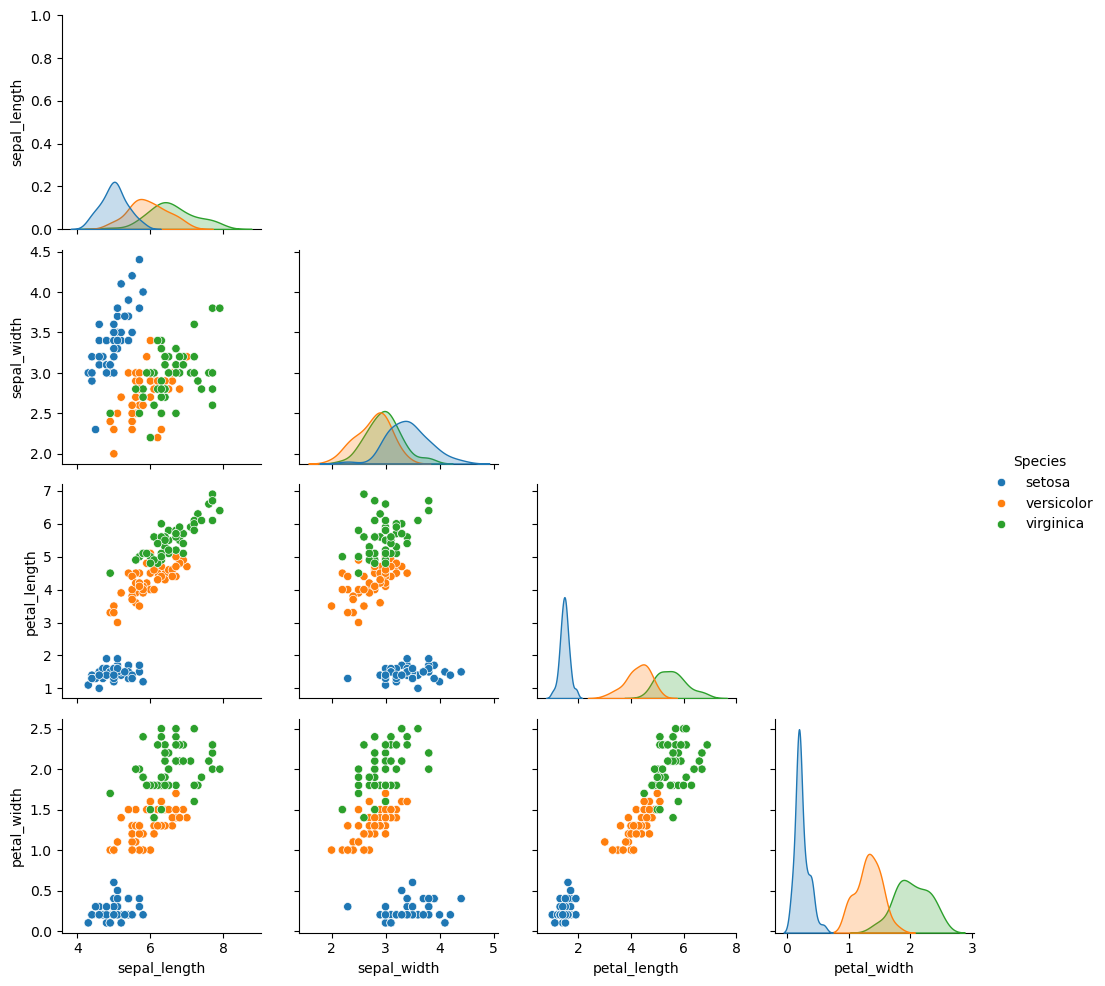

In [8]:
# Create the PairGrid without the upper triangle
# Ensure consistent hue order and palette
g = sns.PairGrid(
    iris_df,
    hue='species',
    corner=False,
    hue_order=species_order,
    palette=species_palette
)

# Map scatter plots to the lower triangle
g.map_lower(sns.scatterplot)

# Map KDE plots to the diagonal
g.map_diag(sns.kdeplot, fill=True)

# Turn off upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

# Add legend
g.add_legend(title='Species')

# Show the plot
plt.show()


### 3.3 Principal Component Analysis (PCA)

In [35]:
iris_features = iris_df.iloc[:, 0:4].values  # assumes first 4 columns are features

# Standardize the features
scaler = StandardScaler()
iris_features_scaled = scaler.fit_transform(iris_features)

# Apply PCA
pca = PCA()
pca_iris = pca.fit_transform(iris_features_scaled)


# Get explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create a DataFrame for better display
variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance': cumulative_variance
})

# Display the variance explained
display(variance_df)

,Principal Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.727705,0.727705
1,PC2,0.230305,0.958010
2,PC3,0.036838,0.994848
3,PC4,0.005152,1.000000


### 3.4 PCA Summary and Variance Explained

In [36]:
# Show variance explained
print("Explained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.4f} ({var*100:.1f}%)")

print("\nCumulative explained variance:")
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(cumulative_var):
    print(f"PC{i+1}: {var:.4f} ({var*100:.1f}%)")

# Show loadings (rotation matrix)
print("\nPCA Loadings (Rotation Matrix):")
loadings_df = pd.DataFrame(pca.components_.T, 
                          columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                          index=iris_df.columns[:4])
print(loadings_df)

Explained variance ratio:
PC1: 0.7277 (72.8%)
PC2: 0.2303 (23.0%)
PC3: 0.0368 (3.7%)
PC4: 0.0052 (0.5%)

Cumulative explained variance:
PC1: 0.7277 (72.8%)
PC2: 0.9580 (95.8%)
PC3: 0.9948 (99.5%)
PC4: 1.0000 (100.0%)

PCA Loadings (Rotation Matrix):
                   PC1       PC2       PC3       PC4
sepal_length  0.522372  0.372318  0.721017 -0.261996
sepal_width  -0.263355  0.925556 -0.242033  0.124135
petal_length  0.581254  0.021095 -0.140892  0.801154
petal_width   0.565611  0.065416 -0.633801 -0.523546


### 3.5 Scree Plot

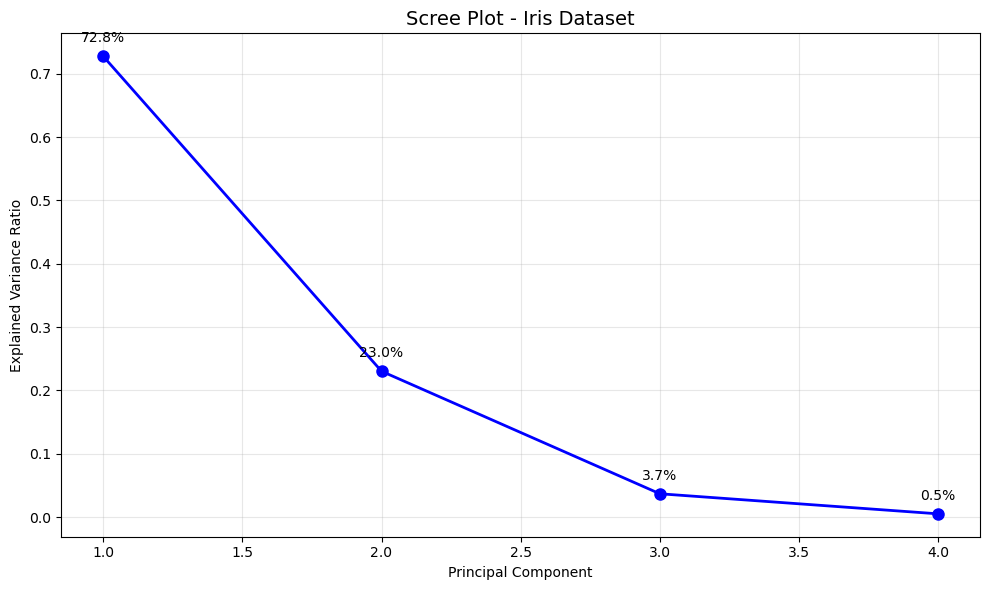

In [37]:
# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_, 'bo-', linewidth=2, markersize=8)
plt.title('Scree Plot - Iris Dataset', fontsize=14)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, alpha=0.3)

# Add percentage labels
for i, var in enumerate(pca.explained_variance_ratio_):
    plt.annotate(f'{var*100:.1f}%', 
                 xy=(i+1, var), 
                 xytext=(0, 10), 
                 textcoords='offset points', 
                 ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 3.6 Code to draw eclipses on the plots

In [44]:
import numpy as np
from matplotlib.patches import Ellipse
from scipy.stats import chi2


def draw_confidence_ellipse(ax, x, y, color, level=0.95, lw=2, alpha=0.15):
    pts = np.column_stack((x, y))
    if pts.shape[0] < 3:
        return
    cov = np.cov(pts, rowvar=False)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    chi2_val = chi2.ppf(level, df=2)
    width, height = 2 * np.sqrt(np.maximum(vals, 1e-12) * chi2_val)
    mean = pts.mean(axis=0)
    e = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=angle,
        edgecolor=color,
        facecolor=color,
        lw=lw,
        alpha=alpha,
    )
    ax.add_patch(e)


### 3.7 Visulize the first two dimensions, i.e. PC1 and PC2

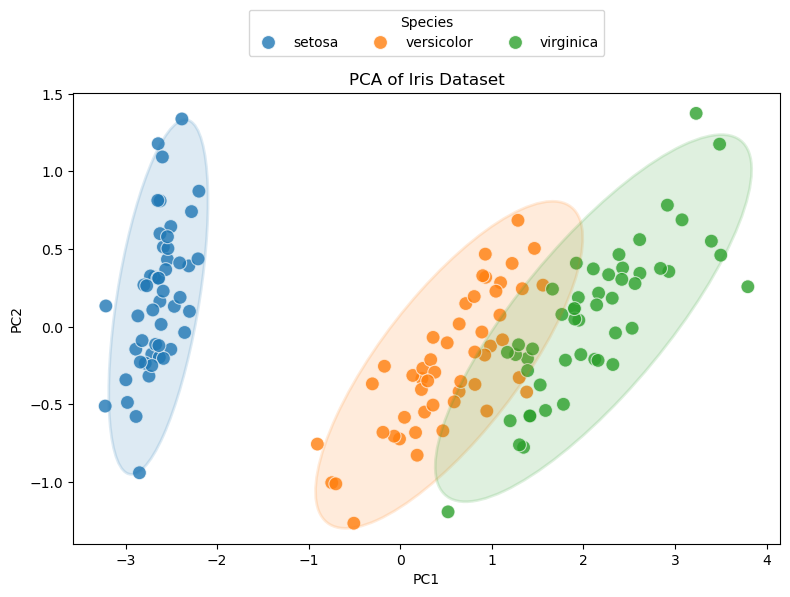

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# Load data and PCA as before
iris = load_iris()
X = iris.data
y = iris.target
species = pd.Categorical.from_codes(y, iris.target_names)

pca = PCA(n_components=2)
pca_scores = pca.fit_transform(X)

pca_df = pd.DataFrame(pca_scores, columns=['PC1', 'PC2'])
pca_df['Species'] = species

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2', hue='Species', s=100, alpha=0.8,
    hue_order=species_order, palette=species_palette
)

# Overlay 95% confidence ellipses per species
ax = plt.gca()
for sp in species_order:
    m = pca_df['Species'] == sp
    draw_confidence_ellipse(ax, pca_df.loc[m, 'PC1'], pca_df.loc[m, 'PC2'], species_palette[sp]) # Draw the eclipse on the plot

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Iris Dataset')

# Adjust legend - move it slightly above the plot and add spacing with top
plt.legend(title='Species', loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)

# Increase top margin to prevent overlap between title and legend
plt.subplots_adjust(top=0.8)

plt.grid(False)
plt.tight_layout()
plt.show()


### 3.8 3D PCA Plot

Columns in pca_df_3d: Index(['PC1', 'PC2', 'PC3', 'Species'], dtype='object')
Unique species values: ['setosa' 'versicolor' 'virginica']
Species: setosa, Points: 50
Species: versicolor, Points: 50
Species: virginica, Points: 50


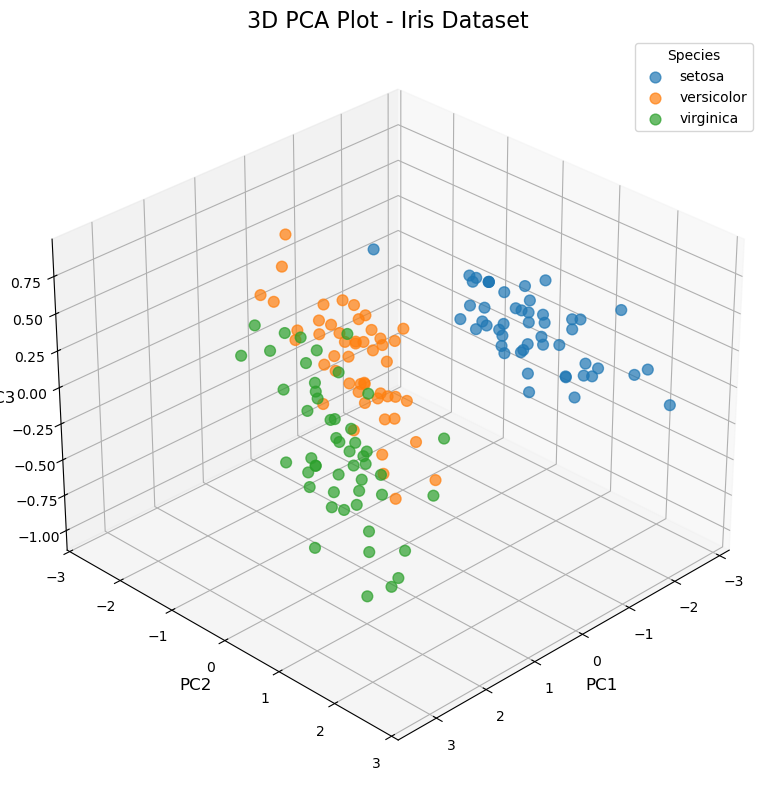

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Create 3D PCA results using existing scaled data
# The existing pca object already has all components, we just need to extract the first 3
pca_3d_scores = pca_iris[:, :3]  # Take first 3 components from existing pca_iris

# Create DataFrame with 3D PCA results using existing iris_df
pca_df_3d = pd.DataFrame(pca_3d_scores, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['Species'] = iris_df['species']  # Use species column from existing iris_df

# Use the global species_palette for consistent colors

# Check column names and unique species in your DataFrame
print("Columns in pca_df_3d:", pca_df_3d.columns)
print("Unique species values:", pca_df_3d['Species'].unique())

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for species_name in species_order:
    mask = pca_df_3d['Species'] == species_name
    # Debug print count of points for each species
    print(f"Species: {species_name}, Points: {mask.sum()}")
    
    if mask.sum() == 0:
        print(f"Warning: No data found for species '{species_name}'")
        continue
    
    ax.scatter(
        pca_df_3d.loc[mask, 'PC1'],
        pca_df_3d.loc[mask, 'PC2'],
        pca_df_3d.loc[mask, 'PC3'],
        c=species_palette[species_name],
        label=species_name,
        alpha=0.7,
        s=60
    )

ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
ax.set_title('3D PCA Plot - Iris Dataset', fontsize=16)
ax.legend(title='Species')

# Set the viewing angle: e.g. elev=30°, azim=45°
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


### 3.9 PCA Biplot

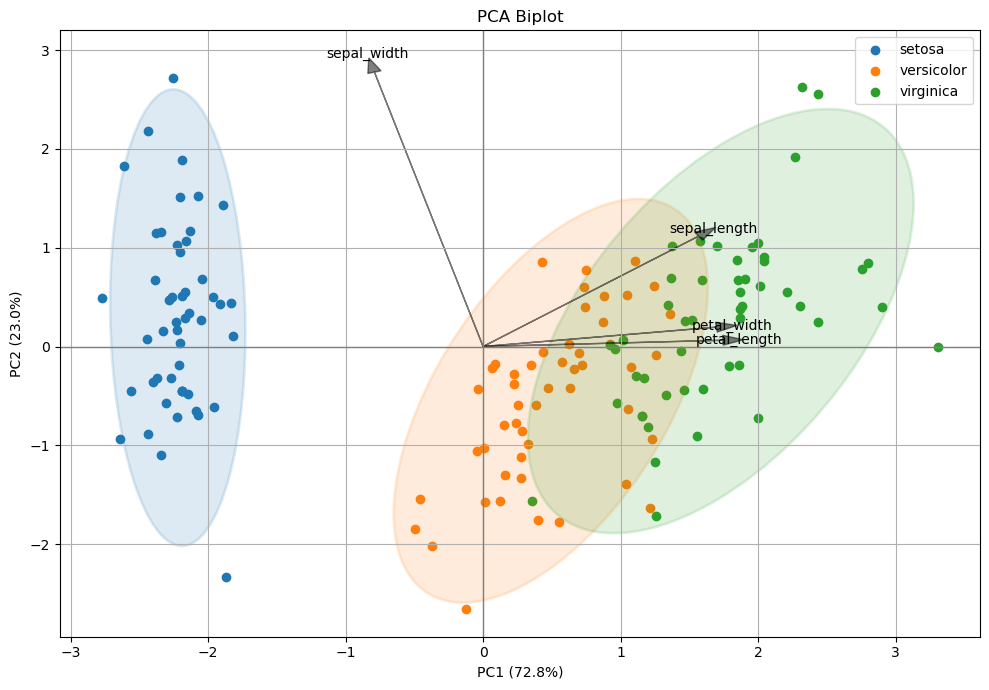

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset
df = iris_df
X = df.iloc[:, :4]
y = df['species']  # for coloring

# Standardize
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get loadings
loadings = pca.components_.T
features = X.columns

# Create figure
plt.figure(figsize=(10, 7))

# Scatter plot of PCA scores, color by species using global palette
for sp in species_order:
    idx = y == sp
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=sp, color=species_palette[sp])

# Overlay 95% confidence ellipses
ax = plt.gca()
for sp in species_order:
    idx = y == sp
    draw_confidence_ellipse(ax, X_pca[idx, 0], X_pca[idx, 1], species_palette[sp])

# Plot the vectors (loadings)
for i, feature in enumerate(features):
    plt.arrow(0, 0, 
              loadings[i, 0]*3,  # scale for visibility
              loadings[i, 1]*3, 
              color='black', alpha=0.5, head_width=0.1)
    plt.text(loadings[i, 0]*3.2, 
             loadings[i, 1]*3.2, 
             feature, color='black', ha='center', va='center')

# Axis labels with variance explained
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA Biplot')
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.legend()
plt.tight_layout()
plt.show()


### 3.10 Principal Coordinate Analysis (PCoA)

Proportion of variance explained by 1st two dimensions (Iris PCoA):
Dim1: 0.6519
Dim2: 0.0741


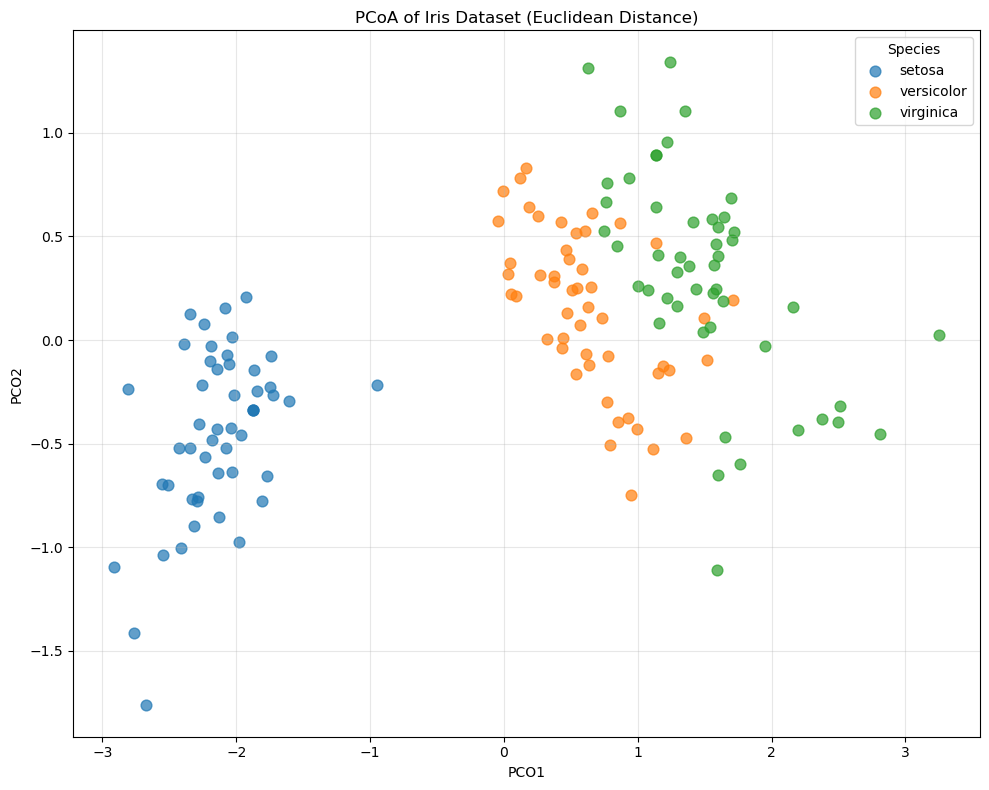

PCoA completed! Stress: 10.6751
Number of samples: 150
Number of features: 4


In [63]:
# Perform PCoA on Iris dataset using Euclidean distance
from sklearn.manifold import MDS

# Use the existing iris features (already standardized from earlier cells)
# iris_features_scaled is available from the main PCA analysis

# Calculate Euclidean distance matrix
distances_iris = pdist(iris_features_scaled, metric='euclidean')
dist_matrix_iris = squareform(distances_iris)

# Perform PCoA (MDS with metric=True) using Euclidean distance
mds_iris = MDS(n_components=3, metric=True, random_state=42, dissimilarity='precomputed')
pcoa_iris = mds_iris.fit_transform(dist_matrix_iris)

# Create DataFrame for PCoA results
pcoa_iris_df = pd.DataFrame(pcoa_iris, columns=['Dim1', 'Dim2', 'Dim3'])
pcoa_iris_df['Species'] = iris_df['species']

# Calculate proportion of variance explained by first two dimensions
total_variance_iris = np.sum(pcoa_iris**2, axis=0)
variance_explained_iris = total_variance_iris / np.sum(total_variance_iris)
print(f"Proportion of variance explained by 1st two dimensions (Iris PCoA):")
print(f"Dim1: {variance_explained_iris[0]:.4f}")
print(f"Dim2: {variance_explained_iris[1]:.4f}")

# Plot PCoA results
fig, ax = plt.subplots(figsize=(10, 8))

for species_name in species_order:
    mask = pcoa_iris_df['Species'] == species_name
    ax.scatter(
        pcoa_iris_df.loc[mask, 'Dim1'], 
        pcoa_iris_df.loc[mask, 'Dim2'], 
        c=species_palette[species_name], 
        label=species_name, 
        alpha=0.7, 
        s=60
    )

ax.set_xlabel('PCO1')
ax.set_ylabel('PCO2')
ax.set_title('PCoA of Iris Dataset (Euclidean Distance)')
ax.legend(title='Species')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCoA completed! Stress: {mds_iris.stress_:.4f}")
print(f"Number of samples: {len(pcoa_iris_df)}")
print(f"Number of features: {len(iris_df.columns)-1}")  # Exclude species column

In [50]:
# Load breast cancer dataset
bc_data = load_breast_cancer()
bc_df = pd.DataFrame(bc_data.data, columns=bc_data.feature_names)
bc_df['target'] = bc_data.target

# Remove any missing values
bc_df = bc_df.dropna()

print("Breast Cancer dataset shape:", bc_df.shape)
print("Number of features:", len(bc_data.feature_names))
bc_df.head()

Breast Cancer dataset shape: (569, 31)
Number of features: 30


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### 3.11 Spider Dataset Simulation

Since the spider dataset is not readily available in Python, we'll create a simulated version to demonstrate the concept.

In [5]:
# Create simulated spider abundance data
url = "https://raw.githubusercontent.com/asim-cv/MAT6206/refs/heads/main/Datasets/Spider.csv"
spider_df = pd.read_csv(url)

print("Spider Abundance Data:")
print(f"Shape: {spider_df.shape}")

spider_df.head()

Spider Abundance Data:
Shape: (28, 12)


,Alopacce,Alopcune,Alopfabr,Arctlute,Arctperi,Auloalbi,Pardlugu,Pardmont,Pardnigr,Pardpull,Trocterr,Zoraspin
0,25,10,0,0,0,4,0,60,12,45,57,4
1,0,2,0,0,0,30,1,1,15,37,65,9
2,15,20,2,2,0,9,1,29,18,45,66,1
3,2,6,0,1,0,24,1,7,29,94,86,25
4,1,20,0,2,0,9,1,2,135,76,91,17


### 3.12 Spider PCoA Analysis

Proportion of variance explained by 1st two dimensions:
PCO1: 0.3563
PCO2: 0.3362


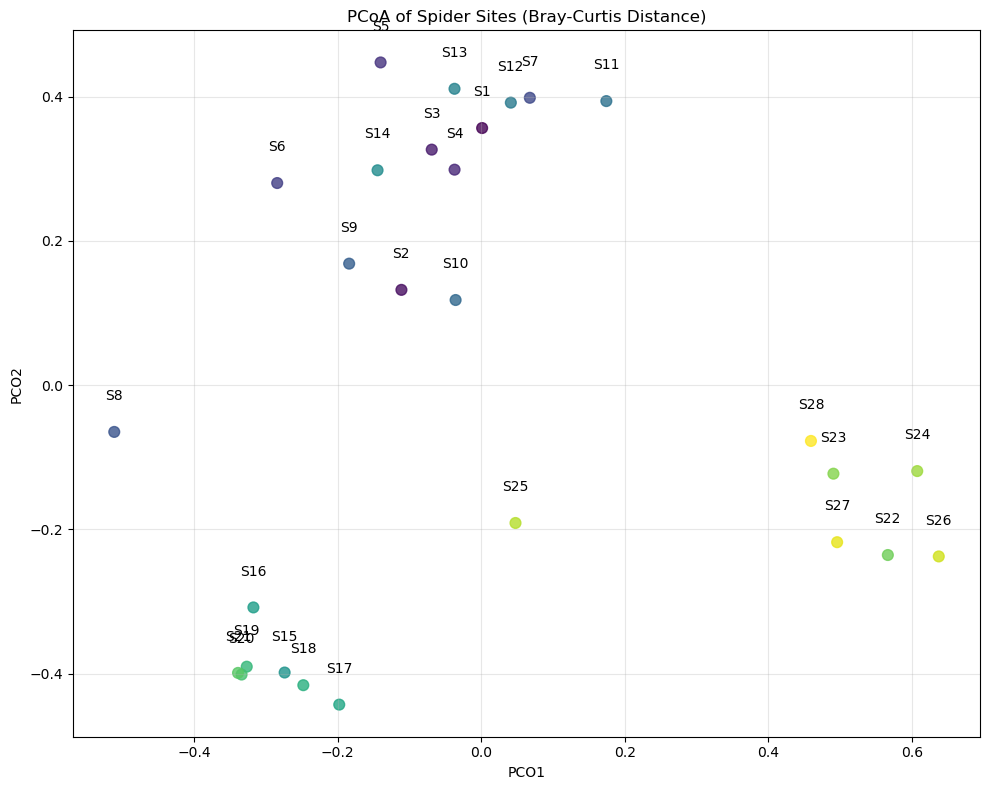

Number of sites: 28
Number of species: 12


In [67]:
# Perform PCoA on spider abundance data
from scipy.spatial.distance import braycurtis
from sklearn.manifold import MDS

# Calculate Bray-Curtis distance matrix
dist_spider = pdist(spider_df.values, metric=braycurtis)
dist_matrix_spider = squareform(dist_spider)

# Perform PCoA 
mds_spider = MDS(n_components=3, metric=True, random_state=42, dissimilarity='precomputed')
pcoa_spider = mds_spider.fit_transform(dist_matrix_spider)

# Calculate proportion of variance explained by first two dimensions
total_variance = np.sum(pcoa_spider**2, axis=0)
variance_explained = total_variance / np.sum(total_variance)
print(f"Proportion of variance explained by 1st two dimensions:")
print(f"PCO1: {variance_explained[0]:.4f}")
print(f"PCO2: {variance_explained[1]:.4f}")

# Plot the first two dimensions
fig, ax = plt.subplots(figsize=(10, 8))

# Create heat colors for 28 sites
colors = plt.cm.viridis(np.linspace(0, 1, 28))

# Plot points
scatter = ax.scatter(pcoa_spider[:, 0], pcoa_spider[:, 1], 
                     c=colors, alpha=0.8, s=60)

# Add site labels
for i in range(28):
    ax.annotate(f'S{i+1}', 
                (pcoa_spider[i, 0], pcoa_spider[i, 1] + 0.04),
                ha='center', va='bottom', fontsize=10)

ax.set_xlabel('PCO1')
ax.set_ylabel('PCO2')
ax.set_title('PCoA of Spider Sites (Bray-Curtis Distance)')
ax.grid(True, alpha=0.3)

# Remove legend
plt.tight_layout()
plt.show()

print(f"Number of sites: {len(spider_df)}")
print(f"Number of species: {len(spider_df.columns)}")

Proportion of variance explained by 1st two dimensions (Species):
PCO1: 0.5316
PCO2: 0.4684


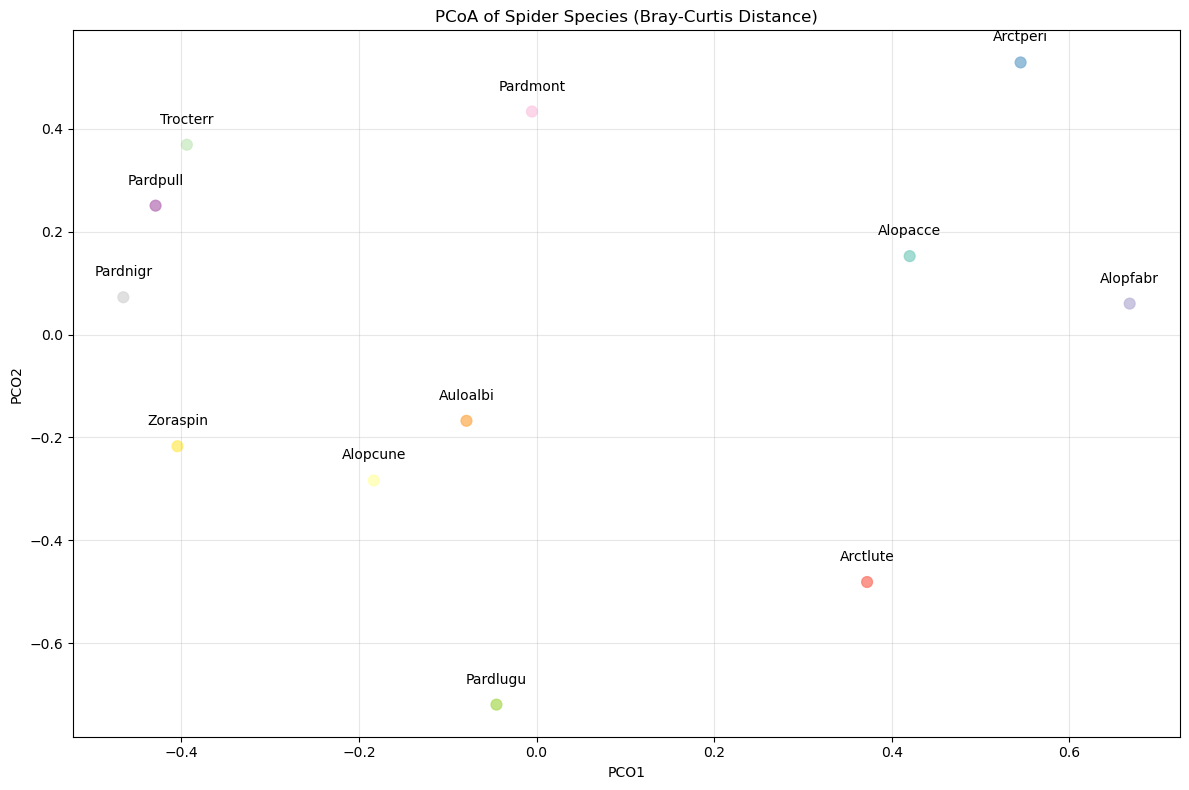

Number of species: 12
Species names: ['Alopacce', 'Alopcune', 'Alopfabr', 'Arctlute', 'Arctperi', 'Auloalbi', 'Pardlugu', 'Pardmont', 'Pardnigr', 'Pardpull', 'Trocterr', 'Zoraspin']


In [66]:
# Calculate Bray-Curtis distance matrix for species (transpose of spider_df)
dist_spider2 = pdist(spider_df.T.values, metric=braycurtis)
dist_matrix_spider2 = squareform(dist_spider2)

# Perform PCoA on species
mds_spider2 = MDS(n_components=2, metric=True, random_state=42, dissimilarity='precomputed')
pcoa_spider2 = mds_spider2.fit_transform(dist_matrix_spider2)

# Calculate proportion of variance explained by first two dimensions
total_variance2 = np.sum(pcoa_spider2**2, axis=0)
variance_explained2 = total_variance2 / np.sum(total_variance2)
print(f"Proportion of variance explained by 1st two dimensions (Species):")
print(f"PCO1: {variance_explained2[0]:.4f}")
print(f"PCO2: {variance_explained2[1]:.4f}")

# Plot the first two dimensions
fig, ax = plt.subplots(figsize=(12, 8))

# Get species names 
species_names = spider_df.columns.tolist()

# Plot points with different colors for each species
colors = plt.cm.Set3(np.linspace(0, 1, len(species_names)))
scatter = ax.scatter(pcoa_spider2[:, 0], pcoa_spider2[:, 1], 
                     c=colors, alpha=0.8, s=60)

# Add species labels 
for i, species in enumerate(species_names):
    ax.annotate(species, 
                (pcoa_spider2[i, 0], pcoa_spider2[i, 1] + 0.035),
                ha='center', va='bottom', fontsize=10)

ax.set_xlabel('PCO1')
ax.set_ylabel('PCO2')
ax.set_title('PCoA of Spider Species (Bray-Curtis Distance)')
ax.grid(True, alpha=0.3)

# Remove legend
plt.tight_layout()
plt.show()

print(f"Number of species: {len(species_names)}")
print(f"Species names: {species_names}")

## Summary

This notebook demonstrates:

1. **Principal Component Analysis (PCA)**: Dimensionality reduction technique that finds orthogonal directions of maximum variance
2. **Principal Coordinate Analysis (PCoA)**: Similar to PCA but works with distance matrices
3. **Visualization**: Various plots including scatter matrices, biplots, and 3D plots
3. **Distance Metrics**: Euclidean distance for continuous data and Bray-Curtis for abundance data

The analysis shows how these techniques can reveal patterns in high-dimensional data and help visualize relationships between samples and variables.